In [8]:
from qiskit import __version__
print(__version__)

1.4.2


In [14]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

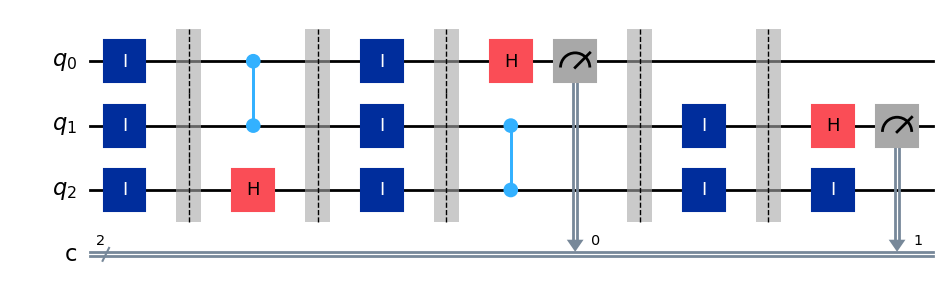

In [10]:
circuit = QuantumCircuit(3, 2)

# Insert errors right after state prep
for a in range(3):
    circuit.id(a)
circuit.barrier()

# CZ on qubits 0,1 and Hadamard on qubit 2
circuit.cz(0,1)
circuit.h(2)
circuit.barrier()

# Errors after the above gates
for j in range(3):
    circuit.id(j)
circuit.barrier()
    
# Measure qubit 0 in X basis, and CZ on qubits 1,2 
circuit.h(0)
circuit.measure(0,0)
circuit.cz(1,2)
circuit.barrier()

# Errors after above CZ gate
for j in range(1, 3):
    circuit.id(j)
circuit.barrier()

# Measure qubit 1 in X basis, and insert error on qubit 2
circuit.h(1)
circuit.measure(1,1)
circuit.id(2)

display(circuit.draw(output='mpl'))

# Results without Noise

Result(backend_name='aer_simulator_statevector', backend_version='0.14.2', qobj_id='', job_id='692878da-800a-40f5-8936-5c6bd5ae574a', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 241, '0x0': 238, '0x2': 254, '0x3': 267}), header=QobjExperimentHeader(creg_sizes=[['c', 2]], global_phase=0.0, memory_slots=2, n_qubits=3, name='circuit-165', qreg_sizes=[['q', 3]], metadata={}), status=DONE, seed_simulator=3118259016, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 12, 'parallel_shots': 1, 'sample_measure_time': 0.000435792, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1, 2], 'device': 'CPU', 'time_taken': 0.001162355, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 32768, 'input_qubit_map': [[2, 2], [1, 1], [0, 0]], 'num_qubits': 3, 'method': 'statevector', 'required_memory_mb': 1, 'fusion': {'enabled

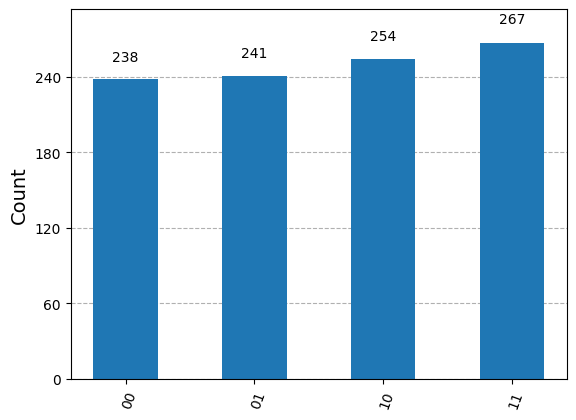

Total counts for measuring 0:  505
Total counts for measuring 1:  495


In [21]:
backend = AerSimulator(method='statevector')

job = backend.run(circuit,shots=1000)
result = job.result()
print(result)

counts = result.get_counts(circuit)
print(counts)
display(plot_histogram(counts)) 

sum0 = counts['00'] + counts['11']
sum1 = counts['01'] + counts['10']
print("Total counts for measuring 0: ", sum0)
print("Total counts for measuring 1: ", sum1)

# Results with Noise

Result(backend_name='aer_simulator_statevector', backend_version='0.14.2', qobj_id='', job_id='267e9b66-eb11-45a5-bc22-b4858a9a363a', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 244, '0x0': 240, '0x3': 285, '0x2': 231}), header=QobjExperimentHeader(creg_sizes=[['c', 2]], global_phase=0.0, memory_slots=2, n_qubits=3, name='circuit-165', qreg_sizes=[['q', 3]], metadata={}), status=DONE, seed_simulator=4005115447, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 1, 'parallel_shots': 12, 'noise': 'circuit', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1, 2], 'device': 'CPU', 'time_taken': 0.03886422, 'measure_sampling': False, 'num_clbits': 2, 'max_memory_mb': 32768, 'input_qubit_map': [[2, 2], [1, 1], [0, 0]], 'num_qubits': 3, 'method': 'statevector', 'required_memory_mb': 1, 'fusion': {'applied': False, 'max_fused_qubits': 5, '

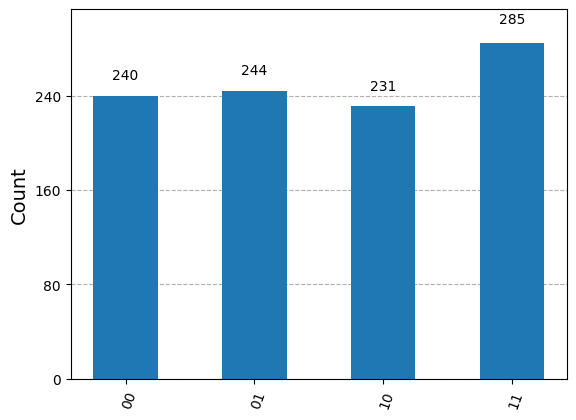

Total counts for measuring 0:  525
Total counts for measuring 1:  475


In [25]:
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cz'])
# Measurement errors?

job = backend.run(circuit, noise_model=noise_model, shots=1000)
result = job.result()
print(result)

noisy_counts = result.get_counts(circuit)
print(noisy_counts)
display(plot_histogram(noisy_counts)) 

noisy_sum0 = noisy_counts['00'] + noisy_counts['11']
noisy_sum1 = noisy_counts['01'] + noisy_counts['10']
print("Total counts for measuring 0: ", noisy_sum0)
print("Total counts for measuring 1: ", noisy_sum1)

# Now I will conduct n number of trials, with each trial consisting of 1000 shots of noiseless and 1000 shots of noisy measurements, and then comparing the results 

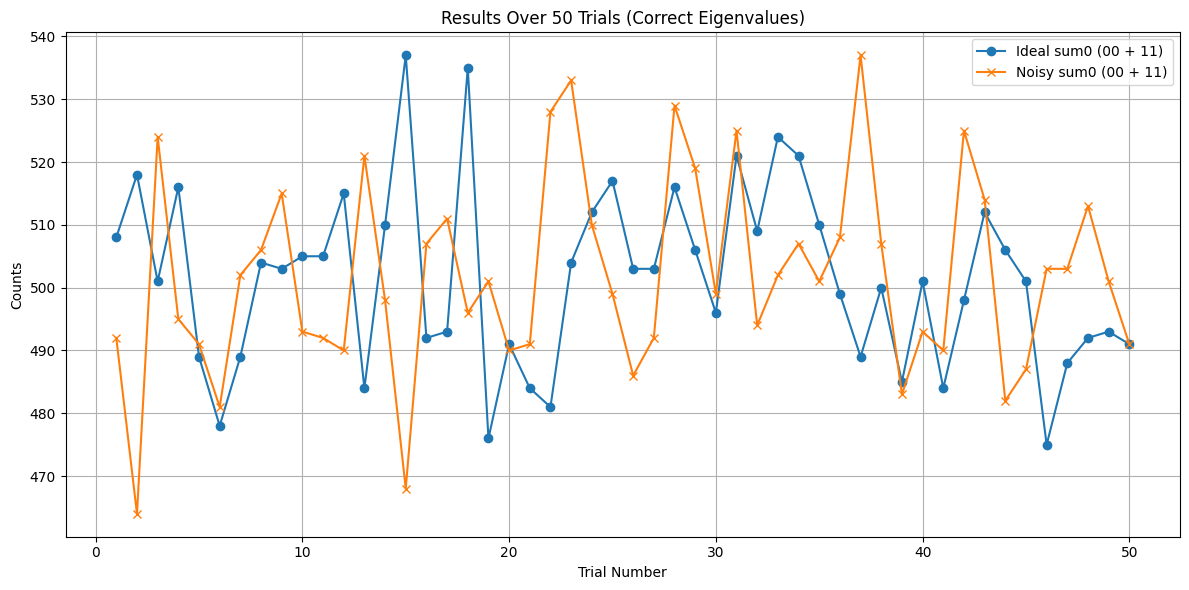

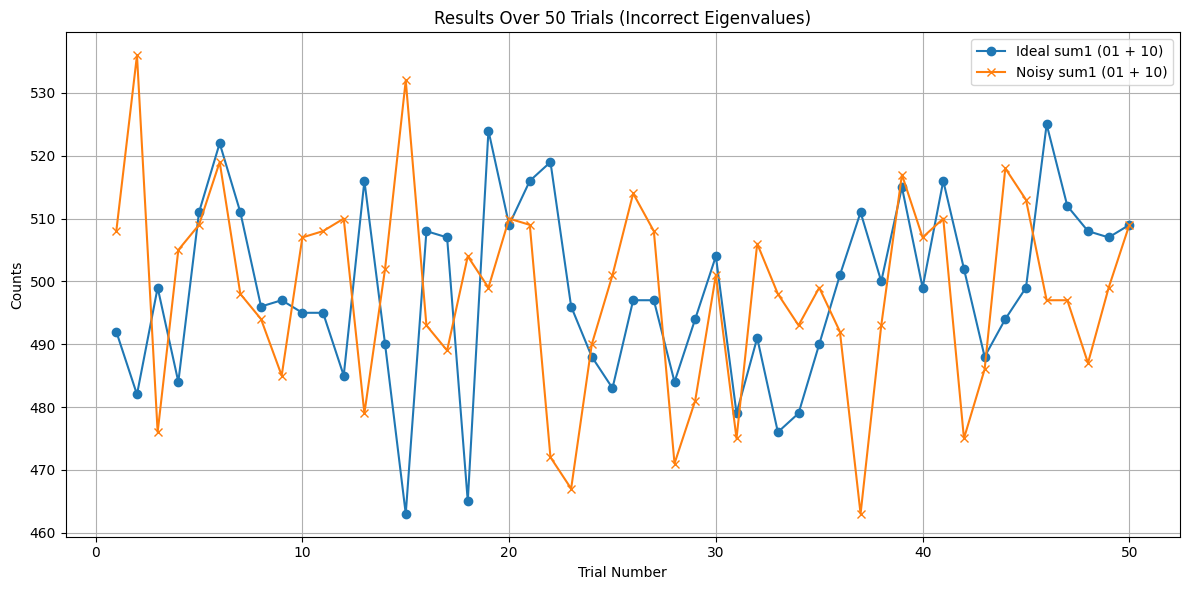

Total counts for ideal circuit and eigenvalues 00, 11:  25070
Total counts for ideal circuit and eigenvalues 01, 10:  24930
Total counts for noisy circuit and eigenvalues 00, 11:  25089
Total counts for noisy circuit and eigenvalues 01, 10:  24911


In [35]:
import matplotlib.pyplot as plt

# Define the noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cz'])

# Lists to collect results
sum0_list = []
sum1_list = []
noisy_sum0_list = []
noisy_sum1_list = []

# Function to build the circuit
def make_circuit():
    circuit = QuantumCircuit(3, 2)

    # Insert errors right after state prep
    for a in range(3):
        circuit.id(a)
    circuit.barrier()

    # CZ on qubits 0,1 and Hadamard on qubit 2
    circuit.cz(0,1)
    circuit.h(2)
    circuit.barrier()

    # Errors after the above gates
    for j in range(3):
        circuit.id(j)
    circuit.barrier()

    # Measure qubit 0 in X basis, and CZ on qubits 1,2 
    circuit.h(0)
    circuit.measure(0,0)
    circuit.cz(1,2)
    circuit.barrier()

    # Errors after above CZ gate
    for j in range(1, 3):
        circuit.id(j)
    circuit.barrier()

    # Measure qubit 1 in X basis, and insert error on qubit 2
    circuit.h(1)
    circuit.measure(1,1)
    circuit.id(2)
    
    return circuit


# Run 20 trials
for trial in range(50):
    qc = make_circuit()
    
    # Run without noise
    result = backend.run(qc, shots=1000).result()
    counts = result.get_counts(qc)
    sum0 = counts.get('00', 0) + counts.get('11', 0)
    sum1 = counts.get('01', 0) + counts.get('10', 0)
    sum0_list.append(sum0)
    sum1_list.append(sum1)

    # Run with noise
    result_noisy = backend.run(qc, noise_model=noise_model, shots=1000).result()
    noisy_counts = result_noisy.get_counts(qc)
    noisy_sum0 = noisy_counts.get('00', 0) + noisy_counts.get('11', 0)
    noisy_sum1 = noisy_counts.get('01', 0) + noisy_counts.get('10', 0)
    noisy_sum0_list.append(noisy_sum0)
    noisy_sum1_list.append(noisy_sum1)

# Plotting
x = list(range(1, 51))
plt.figure(figsize=(12, 6))
plt.plot(x, sum0_list, label='Ideal sum0 (00 + 11)', marker='o')
plt.plot(x, noisy_sum0_list, label='Noisy sum0 (00 + 11)', marker='x')
plt.xlabel('Trial Number')
plt.ylabel('Counts')
plt.title('Results Over 50 Trials (Correct Eigenvalues)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

x = list(range(1, 51))
plt.figure(figsize=(12, 6))
plt.plot(x, sum1_list, label='Ideal sum1 (01 + 10)', marker='o')
plt.plot(x, noisy_sum1_list, label='Noisy sum1 (01 + 10)', marker='x')
plt.xlabel('Trial Number')
plt.ylabel('Counts')
plt.title('Results Over 50 Trials (Incorrect Eigenvalues)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print total values
tot_ideal_sum0 = sum(sum0_list)
tot_noisy_sum0 = sum(noisy_sum0_list)
tot_ideal_sum1 = sum(sum1_list)
tot_noisy_sum1 = sum(noisy_sum1_list)
    
print("Total counts for ideal circuit and eigenvalues 00, 11: ", tot_ideal_sum0)
print("Total counts for ideal circuit and eigenvalues 01, 10: ", tot_ideal_sum1)
print("Total counts for noisy circuit and eigenvalues 00, 11: ", tot_noisy_sum0)
print("Total counts for noisy circuit and eigenvalues 01, 10: ", tot_noisy_sum1)